### Unspliced spliced ratio

In [ ]:
import time
import timeit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from tqdm import tqdm
from scipy.stats import mannwhitneyu

# transparent background
plt.rcParams.update({
    "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  
    "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  
})

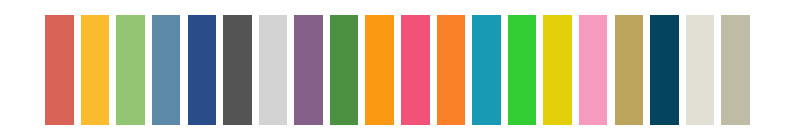

In [2]:
# define colors
purple = '#856088'
pink = '#F25278'
red = '#d96256'
lightgreen = '#93c572'
darkgreen = '#4c9141'
lightblue = '#5d8aa8'
darkblue = '#284d88'
white = '#fafafa'
lightgray = '#d3d3d3'
darkgray ='#545454'
lightorange = '#fabc2e'
darkorange = '#fb9912'
lightyellow = '#e4d00a'
lightgreen2 = '#32CD32'
lightblue2 = '#189AB4'
darkblue2 = '#05445E'
lightpink = '#F79AC0'
darkorange2 = '#FA8128'
darkyellow = '#BDA55D'
lightgray2 = '#E2E0D4'
lightgray3 = '#BFBBA4'

colors = [
    red, lightorange, lightgreen, lightblue, darkblue, 
    darkgray, lightgray, purple, darkgreen, darkorange,
    pink, darkorange2, lightblue2, lightgreen2, lightyellow,
    lightpink, darkyellow, darkblue2, lightgray2, lightgray3
]

plt.figure(figsize=(10, 1.5))
plt.bar(range(len(colors)), height=1, color=colors)
__ = plt.axis('off')

#### load processed stereoseq unsp/sp ratios

In [3]:
# gene lists
path = '../ella/input/stereoseq_data_dict_bkp.pkl'
pickle_dict = pd.read_pickle(path)
type_list = pickle_dict['type_list']
gene_list_dict = pickle_dict['gene_list_dict']
del pickle_dict

# ratios
path = '../stereoseq_res.pkl'
pickle_dict = pd.read_pickle(path)
ratio_dict = pickle_dict['stereoseq_ratio_dict']
ncavl_dict = pickle_dict['stereoseq_ncavl_dict']
del pickle_dict

#### load ella results

In [4]:
# load ella results
fn = '../ella/output_ella/ella_stereoseq_t1t20.pkl'
res_dict = pd.read_pickle(fn)
types_list = res_dict['types_list']
genes_dict = res_dict['genes_dict']
p_fdr_dict = res_dict['p_fdr_dict']
score_dict = res_dict['score_dict']
label_dict = res_dict['label_dict']
del res_dict

#### compute radio df

In [5]:
ratio_df_dict = {}

for t in types_list:
    gl_t = genes_dict[t]
    gl_ro_t = gene_list_dict[t]
    ro_t = ratio_dict[t]
    p_t = p_fdr_dict[t]
    label_t = label_dict[t]
    score_t = score_dict[t]
    ratio_t = []
    for g in gl_t:
        if g in gl_ro_t:
            idx_ro = np.where(np.array(gl_ro_t)==g)[0][0]
            ro = ro_t[idx_ro]
            ratio_t.append(ro)
        else:
            ratio_t.append(np.nan)

    ratio_df_dict[t] = pd.DataFrame({'gene':gl_t, 'pv':p_t, 'label':label_t, 'score':score_t, 'ratio':ratio_t})

#### all types together

In [6]:
# merged df
merged_df = pd.concat(ratio_df_dict.values(), ignore_index=True)
merged_df = merged_df[merged_df.ratio>=0]
merged_df.head(3)

,gene,pv,label,score,ratio
1,Hbb-bs,2.000000,-1,0.585687,0.125726
2,Lars2,0.000003,2,0.404232,0.127649
3,Malat1,0.000003,1,0.101808,0.197686


In [7]:
merged_df.groupby('label').ratio.mean()

label
-1    0.802139
 0    3.028662
 1    2.844949
 2    2.323808
 3    1.556298
 4    0.671438
Name: ratio, dtype: float64

In [8]:
# wilcoxon cluster 1-3 vs 4-5 
sample1 = merged_df['ratio'][(merged_df.label==0)|(merged_df.label==1)|(merged_df.label==2)].values
sample2 = merged_df['ratio'][(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value1 = mannwhitneyu(sample1, sample2)
print(f'1-3 vs 4-5 \np={p_value1}')
print(f'fc={np.mean(sample1)/np.mean(sample2)}')
p12 = [p_value1]

# wilcoxon cluster 1-3 vs all else
sample3 = merged_df['ratio'][(merged_df.label==-1)|(merged_df.label==3)|(merged_df.label==4)].values
__statistic, p_value2 = mannwhitneyu(sample1, sample3)
print(f'1-3 vs others \np={p_value2}')
print(f'fc={np.mean(sample1)/np.mean(sample3)}')
p13 = [p_value2]

1-3 vs 4-5 
p=1.396854820160387e-24
fc=2.4239973156028425
1-3 vs others 
p=5.370660654273555e-96
fc=3.3618899923756578


In [23]:
# corr
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p_value = pearsonr(merged_df.ratio, merged_df.score)
print(f'pearson_corr={pearson_corr:.3f} p={pearson_p_value}')

pearson_corr=-0.464 p=1.0944146118205704e-152


In [10]:
# bar plot
means = [
    (merged_df.ratio)[(merged_df.label>=0)&(merged_df.label<=2)].mean(),
    (merged_df.ratio)[(merged_df.label>2)].mean(),
    (merged_df.ratio)[(merged_df.label==-1)|(merged_df.label>2)].mean(),
]

# Individual data points for each category
data_points = [
    (merged_df.ratio)[(merged_df.label>=0)&(merged_df.label<=2)],
    (merged_df.ratio)[(merged_df.label>2)],
    (merged_df.ratio)[(merged_df.label==-1)|(merged_df.label>2)],
]

# remove outliers
lbs = []
ubs = []
data_points2 = []
for j in range(len(data_points)):
    data_j = data_points[j]
    
    # IQR
    Q1 = np.percentile(data_j, 25)
    Q3 = np.percentile(data_j, 75)
    # IQR = Q3 - Q1
    lower_bound = Q1
    upper_bound = Q3
    lbs.append(np.maximum(means[j]-lower_bound,0))
    ubs.append(np.maximum(upper_bound-means[j],0))
    
    data_j2 = data_j[(data_j >= lower_bound) & (data_j <= upper_bound)]
    
    data_points2.append(data_j2)

In [11]:
def sig_symb(p_value):
    if p_value <= 0.001:
        sig_symbol = '***'
    elif p_value <= 0.01:
        sig_symbol = '**'
    elif p_value <= 0.05:
        sig_symbol = '*'
    else:
        sig_symbol = ''
    return sig_symbol

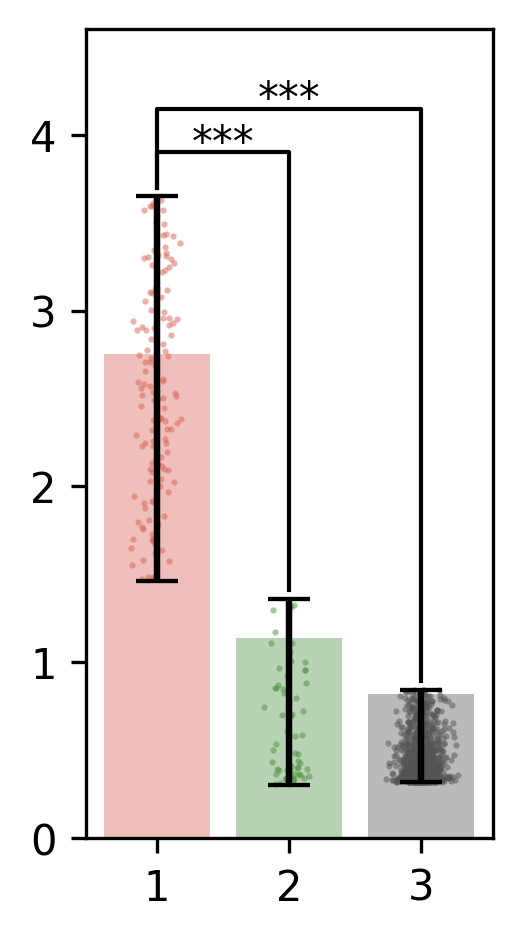

In [21]:
nr = 1
nc = 1
ss_nr = 3.5
ss_nc = 7/4
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr,nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
ax = plt.subplot(gs[0, 0])

colors = [red, darkgreen, darkgray]
bar_pos = np.array([1,2,3])

# bar
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              color=colors,
              zorder=1,
              alpha=0.4)
# the std 
bars = ax.bar(bar_pos, means, yerr=np.array([lbs, ubs]), 
              capsize=5, 
              zorder=3,
              alpha=0)

# Define the width of the spread
width = bars[0].get_width() / 1.0

# Adding spread dots
for _i, (i, data) in enumerate(zip(bar_pos, data_points2)):
    # Spread dots around the center of the bar
    x = np.random.normal(i, width/10, size=len(data))
    ax.plot(x, data, '.', 
            color=colors[_i], 
            markersize=3,
            markeredgewidth=0, mec='none', alpha=0.5, zorder=1)

# add 1 vs 2-5 pv
hgap_big = 0.25
hgap_small = 0.05
for j, p in enumerate(p12[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+1
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+1]+ubs[j*3+1]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
# add 1 vs others pv
hgap_big = 0.25*2
hgap_small = 0.05
for j, p in enumerate(p13[:]):
    x1 = bar_pos[::3][j]
    x2 = x1+2
    bar1_max = means[j*3]+ubs[j*3]
    bar2_max = means[j*3+2]+ubs[j*3+2]
    bar12_max = np.maximum(bar1_max, bar2_max)
    
    if p<=0.05:
        ax.plot(
            [x1, x1, x2, x2],
            [bar1_max+hgap_small, bar12_max+hgap_big, bar12_max+hgap_big, bar2_max+hgap_small],
            lw=1, 
            color='black'
        )

        ax.text((x1+x2)/2, bar12_max+hgap_big+hgap_small, sig_symb(p), ha='center', va='center')
    
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_ylim((0, 4.6))

# plt.savefig(f'figs/fig_unsp_all.pdf', dpi=300, bbox_inches='tight')